In [17]:
import re
import json
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

### Parse and filter dataset

In [5]:
dataset = load_dataset('d0rj/gsm8k-ru')

Generating test split: 100%|██████████| 1319/1319 [00:00<00:00, 228154.36 examples/s]


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})

In [7]:
# pd.DataFrame(dataset['train']).to_csv('gsm_raw_train.csv', index=False)
# pd.DataFrame(dataset['test']).to_csv('gsm_raw_test.csv', index=False)
# df_train = pd.read_csv('gsm_raw_train.csv')
# df_test = pd.read_csv('gsm_raw_test.csv')

df_train = pd.DataFrame(dataset['train'])
df_train['is_train'] = True
df_test = pd.DataFrame(dataset['test'])
df_test['is_train'] = False
df_all = pd.concat([df_train, df_test], axis=0)
df_all

,question,answer,is_train
0,В апреле Наталья продала клипы 48 своим друзья...,Наталья продала 48/2 = <<48/2=24>>24 ролика в ...,True
1,Венг зарабатывает 12 долларов в час за присмот...,"Венг зарабатывает 12/60 = $<<12/60=0,2>>0,2 в ...",True
2,"Бетти копит деньги на новый бумажник, который ...",Вначале у Бетти всего 100/2 = $<<100/2=50>>50....,True
3,Джули читает книгу на 120 страниц. Вчера она с...,Сегодня Майла прочитала 12 x 2 = <<12*2=24>>24...,True
4,Джеймс пишет письмо на 3 страницы 2 разным дру...,Он пишет каждому другу 3*2=<<3*2=6>>6 страниц ...,True
...,...,...,...
1314,"У Джона родился сын Джеймс, когда ему было 19....","Доре 12-3=<<12-3=9>>9\nИтак, Джеймсу 9*2=<<9*2...",False
1315,В корзине несколько апельсинов. Ана тратит 3 м...,В часе 60 минут. Ана чистит апельсин за 3 мину...,False
1316,"У Марка сломалась машина, и ему нужно купить н...",Скидка на радиатор составила 400*.8=$<<400*.8=...,False
1317,"У фермера Брауна на ферме 20 животных, все кур...",Пусть С - количество цыплят.\nЕсть коровы 20-С...,False


In [8]:
assert df_all.duplicated('question').sum() == 0
assert df_all.duplicated('answer').sum() == 0

# import difflib
# df_all['similar'] = [
#     len(difflib.get_close_matches(x, df_all['question'], cutoff=0.7)) > 1
#     for x in df_all['question']
# ]
# df_all

In [9]:
def is_answer_ok(answer):
    if answer.count('<<') == 0 or answer.count('>>') == 0:
        # print('|', end='')
        return False
    if answer.count('<<<') > 0 or answer.count('>>>') > 0:
        # print('|', end='')
        return False
    if answer.count('<<') != answer.count('>>'):
        # print('|', end='')
        return False
    return True


def normalize_decimal(re_match):
    str_val = re_match[0]
    if '.' in str_val:
        if str_val.startswith('.'):
            str_val = '0' + str_val
        str_val = str_val.rstrip('0').rstrip('.')
    return str_val


def parse_call(call):
    if not re.fullmatch(r'<<[0-9\+\-–\*/()\.,]+=-?[0-9\.,]+>>', call):
        # print('|', end='')
        return None
    assert call.count('=') == 1
    lhs, rhs = call[2:-2].replace(',', '.').replace('–', '-') \
        .replace('*01', '*0.01').replace('*06', '*0.06').split('=')
    lhs, rhs = lhs.strip(), rhs.strip()
    lhs = lhs.replace('+', ' + ').replace('-', ' - ') \
        .replace('*', ' * ').replace('/', ' / ').strip()
    # lhs = re.sub(r'(^| )0+ \+ ', '', lhs)
    if lhs.startswith('+'):
        lhs = lhs[2:]
    if all(x not in '+-*/' for x in lhs):
        float(lhs)  # just check it's a number
        # print('|', end='')
        return None
    try:
        lhs_eval_res = round(eval(lhs), 10)
    except SyntaxError as err:
        # print(lhs, '=', rhs, err)
        return None
    if float(lhs_eval_res) != float(rhs):
        # print('|', end='')
        return None
    # if re.search(r'(^| )0+ ', lhs):
    #     print('|', end='')
    #     return None
    lhs = re.sub(r'[0-9\.]+', normalize_decimal, lhs)
    rhs = re.sub(r'[0-9\.]+', normalize_decimal, rhs)
    assert lhs[0] in '-0123456789(', lhs
    assert float(round(eval(lhs), 10)) == float(rhs)
    return lhs.strip(), rhs.strip()


def get_calls(answer):
    if not is_answer_ok(answer):
        return None
    calls = [
        re.sub(r'\s', '', x)
        for x in re.findall(r'<<[^>]+>>', answer)
    ]
    result = []
    for call in calls:
        parsed_call = parse_call(call)
        if parsed_call is None:
            return None
        lhs, rhs = parsed_call
        result.append(f'{lhs} = {rhs}')
    assert len(result) > 0
    return result

In [10]:
df_all['calls'] = df_all['answer'].apply(get_calls)
df_filtered = df_all[df_all['calls'].notna()].copy()
df_filtered['num_calls'] = df_filtered['calls'].apply(len)

print('Errors:', df_all['calls'].isna().sum())
print('Train size:', df_filtered['is_train'].sum())
print('Test size:', (~df_filtered['is_train']).sum())
df_filtered

Errors: 778
Train size: 6817
Test size: 1197


,question,answer,is_train,calls,num_calls
0,В апреле Наталья продала клипы 48 своим друзья...,Наталья продала 48/2 = <<48/2=24>>24 ролика в ...,True,"[48 / 2 = 24, 48 + 24 = 72]",2
1,Венг зарабатывает 12 долларов в час за присмот...,"Венг зарабатывает 12/60 = $<<12/60=0,2>>0,2 в ...",True,"[12 / 60 = 0.2, 0.2 * 50 = 10]",2
2,"Бетти копит деньги на новый бумажник, который ...",Вначале у Бетти всего 100/2 = $<<100/2=50>>50....,True,"[100 / 2 = 50, 15 * 2 = 30, 100 - 50 - 30 - 15...",3
3,Джули читает книгу на 120 страниц. Вчера она с...,Сегодня Майла прочитала 12 x 2 = <<12*2=24>>24...,True,"[12 * 2 = 24, 12 + 24 = 36, 120 - 36 = 84, 84 ...",4
4,Джеймс пишет письмо на 3 страницы 2 разным дру...,Он пишет каждому другу 3*2=<<3*2=6>>6 страниц ...,True,"[3 * 2 = 6, 6 * 2 = 12, 12 * 52 = 624]",3
...,...,...,...,...,...
1313,Продавец фруктов купил 50 арбузов за 80 доллар...,Прибыль продавца фруктов от 50 арбузов состави...,False,"[80 * 25 / 100 = 20, 80 + 20 = 100, 100 / 50 = 2]",3
1314,"У Джона родился сын Джеймс, когда ему было 19....","Доре 12-3=<<12-3=9>>9\nИтак, Джеймсу 9*2=<<9*2...",False,"[12 - 3 = 9, 9 * 2 = 18, 18 + 19 = 37, 37 - 32...",5
1315,В корзине несколько апельсинов. Ана тратит 3 м...,В часе 60 минут. Ана чистит апельсин за 3 мину...,False,"[60 / 3 = 20, 60 / 4 = 15, 20 - 15 = 5]",3
1316,"У Марка сломалась машина, и ему нужно купить н...",Скидка на радиатор составила 400*.8=$<<400*.8=...,False,"[400 * 0.8 = 320, 400 - 320 = 80, 3 * 50 = 150...",4


In [19]:
df_filtered[df_filtered['calls'].duplicated(keep=False) & (df_filtered['num_calls'] > 2)].sort_values(by='calls')

,question,answer,is_train,calls,num_calls
5377,Брианна экономит 10 долларов в январе. Каждый ...,Брианна экономит $10 x 2 = $<<10*2=20>>20 в фе...,True,"[10 * 2 = 20, 20 * 2 = 40, 40 * 2 = 80, 80 * 2...",4
2708,Офелия присоединилась к соревнованию по эконом...,Офелия экономит $10 x 2 = $<<10*2=20>>20 в фев...,True,"[10 * 2 = 20, 20 * 2 = 40, 40 * 2 = 80, 80 * 2...",4
309,"Хелена — сумасшедший ученый, тестирующий свое ...","По одной новой руке каждые 3 дня, через 15 дне...",False,"[15 / 3 = 5, 15 / 5 = 3, 5 + 3 = 8]",3
7255,"У Фабиана в три раза больше шариков, чем у Кай...","У Кайла треть шариков Фабиана, поэтому у него ...",True,"[15 / 3 = 5, 15 / 5 = 3, 5 + 3 = 8]",3
5136,У Марио в саду растут 3 гибискуса. Первое раст...,Второе растение гибискуса имеет 2 x 2 = <<2*2=...,True,"[2 * 2 = 4, 4 * 4 = 16, 2 + 4 + 16 = 22]",3
6478,"Боб посадил кукурузу в своем саду, и она тольк...","На второй неделе он вырос в два раза больше, ч...",True,"[2 * 2 = 4, 4 * 4 = 16, 2 + 4 + 16 = 22]",3
2280,Орлан отдал Аллану четверть своей 20-метровой ...,Орлан дал Аллану 20 x 1/4 = <<20*1/4=5>>5 метр...,True,"[20 * 1 / 4 = 5, 20 - 5 = 15, 15 * 2 / 3 = 10,...",4
7040,В аквапарке 20 дельфинов. Четверть дельфинов п...,20 x 1/4 = <<20*1/4=5>>5 дельфинов полностью о...,True,"[20 * 1 / 4 = 5, 20 - 5 = 15, 15 * 2 / 3 = 10,...",4
6127,"Каждый раз, когда Джанет складывает одеяло, ег...",Сначала найдите толщину одеяла после 1 складыв...,True,"[3 * 2 = 6, 6 * 2 = 12, 12 * 2 = 24, 24 * 2 = 48]",4
6169,Томас надеется пробежать марафон в следующем г...,В первый месяц он может пробежать 3 мили.\nВо ...,True,"[3 * 2 = 6, 6 * 2 = 12, 12 * 2 = 24, 24 * 2 = 48]",4


In [20]:
# x =re.sub(r'(\d\.[1-9]+)0+(?!\d)', r'\g<1>', '0.001 2.00 43.1200 5.501000')
# print(x)
# x = re.sub(r'(\d)\.0+(?!\d)', r'\g<1>', x)
# print(x)

In [21]:
def process_call(re_match):
    call = re.sub(r'\s', '', re_match[0])
    lhs, rhs = parse_call(call)
    return f'<calculator>{lhs} = {rhs}</calculator>'


last_answer = [None, None]


def fix_answer(re_match):
    calc_res, actual_res = re_match[0][3:].split('</calculator>')
    assert actual_res.count('.') <= 2, actual_res
    actual_res = actual_res.replace(' ', '').rstrip('.')
    if actual_res[0] not in '0123456789':
        print(calc_res, actual_res)
    if calc_res != actual_res:
        # print(calc_res, actual_res, '\n', last_answer[0], '\n', last_answer[1], '\n')
        return '_DELETE_'
    return f'</calculator>{calc_res}'


def process_answer(answer):
    last_answer[0] = answer

    # Replace strange spaces:
    answer = answer.replace(' ', ' ').replace('\u200b', '')
    # Process call argument:
    answer = re.sub(r'<<[^>]+>>', process_call, answer)
    # Remove spaces after call:
    answer = re.sub(r'</calculator>\s+', r'</calculator>', answer)
    # Replace .\d+ with 0.\d+
    answer = re.sub(r'(</calculator>|\s|\*)(\.|,)(\d)',
                    r'\g<1>0.\g<3>', answer)
    # Remove space betweeen parts of long number:
    answer = re.sub(r'(?<=\d) (\d\d\d)', r'\g<1>', answer)
    # Replace commas with dots for floats:
    answer = re.sub(r'(\d),(\d)', r'\g<1>.\g<2>', answer)
    # Remove trailing zeros for floats:
    answer = re.sub(r'(\d\.[1-9]+)0+(?!\d)', r'\g<1>', answer)
    # The same for integers as floats:
    answer = re.sub(r'(\d)\.0+(?!\d)', r'\g<1>', answer)
    # Add missing spaces between/after math operations:
    answer = re.sub(r'(?<=\d)([\$%\)]*) ?([\+\-\*/=x]) ?([\$\(]*)(?=\d)',
                    r'\g<1> \g<2> \g<3>', answer)
    # Replace `x` as an operator with `*`:
    answer = re.sub(r'(?<=\d)([\$%\)]*) x ([\$\(]*)(?=\d)',
                    r'\g<1> * \g<2>', answer)
    # Add missing spaces between/after equality operator:
    answer = re.sub(r'(?<=\d)([\$%\)]*) ?= ?(\$?)(?=<calculator>)',
                    r'\g<1> = \g<2>', answer)
    # The same when there is no number before:
    answer = re.sub(r' ?= ?(\$?)(?=<calculator>)', r' = \g<1>', answer)

    last_answer[1] = answer
    answer = re.sub(r' = [^<]+</calculator>(\d+\.)?\d+', fix_answer, answer)
    if '_DELETE_' in answer or re.search(r'</calculator>[^\d]', answer) or \
            re.search(r'\d\(', answer):
        # print('|', end='')
        return None
    return answer

In [22]:
df_final = df_filtered.copy()
df_final['answer'] = df_filtered['answer'].apply(process_answer)

print('Errors:', df_final['answer'].isna().sum())
df_final.dropna(inplace=True)
print('Train size:', df_final['is_train'].sum())
print('Test size:', (~df_final['is_train']).sum())
df_final

Errors: 210
Train size: 6632
Test size: 1172


,question,answer,is_train,calls,num_calls
0,В апреле Наталья продала клипы 48 своим друзья...,Наталья продала 48 / 2 = <calculator>48 / 2</c...,True,"[48 / 2 = 24, 48 + 24 = 72]",2
1,Венг зарабатывает 12 долларов в час за присмот...,Венг зарабатывает 12 / 60 = $<calculator>12 / ...,True,"[12 / 60 = 0.2, 0.2 * 50 = 10]",2
2,"Бетти копит деньги на новый бумажник, который ...",Вначале у Бетти всего 100 / 2 = $<calculator>1...,True,"[100 / 2 = 50, 15 * 2 = 30, 100 - 50 - 30 - 15...",3
3,Джули читает книгу на 120 страниц. Вчера она с...,Сегодня Майла прочитала 12 * 2 = <calculator>1...,True,"[12 * 2 = 24, 12 + 24 = 36, 120 - 36 = 84, 84 ...",4
4,Джеймс пишет письмо на 3 страницы 2 разным дру...,Он пишет каждому другу 3 * 2 = <calculator>3 *...,True,"[3 * 2 = 6, 6 * 2 = 12, 12 * 52 = 624]",3
...,...,...,...,...,...
1312,Ресторан Тома получает 6 бронирований за ночь....,Питание стоит 2 * 5 = $<calculator>2 * 5</calc...,False,"[2 * 5 = 10, 10 + 5 = 15, 6 * 15 = 90, 90 * 2 ...",4
1313,Продавец фруктов купил 50 арбузов за 80 доллар...,Прибыль продавца фруктов от 50 арбузов состави...,False,"[80 * 25 / 100 = 20, 80 + 20 = 100, 100 / 50 = 2]",3
1314,"У Джона родился сын Джеймс, когда ему было 19....",Доре 12 - 3 = <calculator>12 - 3</calculator>9...,False,"[12 - 3 = 9, 9 * 2 = 18, 18 + 19 = 37, 37 - 32...",5
1316,"У Марка сломалась машина, и ему нужно купить н...",Скидка на радиатор составила 400 * 0.8 = $<cal...,False,"[400 * 0.8 = 320, 400 - 320 = 80, 3 * 50 = 150...",4


In [23]:
def try_cast_to_int(result):
    if '.' in result:
        left, right = result.split('.', 1)
        if set(right) == {'0'}:
            result = left
    return result


def get_processed_calls(answer):
    return [
        f'{x} = {try_cast_to_int(str(round(eval(x), 10)))}'
        for x in re.findall(
            r'(?<=<calculator>)[^<]+(?=</calculator>)', answer
        )
    ]

### Post-filtering

In [24]:
assert (df_final['answer'].apply(get_processed_calls) != df_final['calls']).sum() == 0

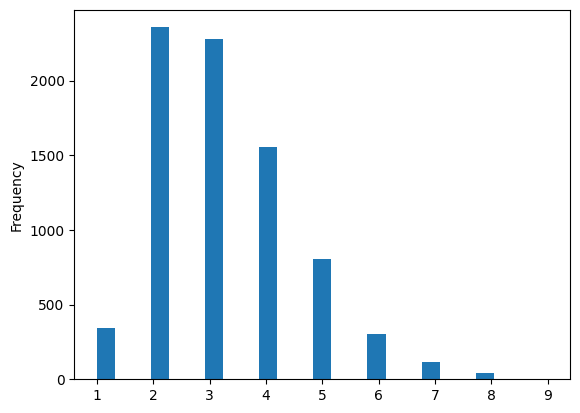

In [29]:
_ = df_final['num_calls'].plot.hist(bins=25)

In [26]:
df_final[df_final['is_train'] & (df_final['num_calls'] <= 6)]['num_calls'].value_counts() / (df_final['is_train']).sum() * (~df_final['is_train']).sum()

num_calls
2    358.032569
3    343.895054
4    228.320869
5    120.699035
1     51.778649
6     45.240048
Name: count, dtype: float64

In [27]:
df_final[~df_final['is_train'] & (df_final['num_calls'] <= 6)]['num_calls'].value_counts()
# NOTE: it's ok to just stratify using test set

num_calls
3    334
2    331
4    261
5    122
1     51
6     49
Name: count, dtype: int64

In [30]:
_df_test = df_final[~df_final['is_train'] & (df_final['num_calls'] <= 6)]
df_add_to_train, df_test = train_test_split(
    _df_test, test_size=400,
    random_state=42, stratify=_df_test['num_calls']
)
df_train = pd.concat((df_final[df_final['is_train'] | (df_final['num_calls'] > 6)], df_add_to_train, df_test))
assert len(df_train) == len(df_final)

df_train.drop(columns=['is_train', 'num_calls', 'calls'], inplace=True)

In [31]:
df_train.to_csv('gsm_8k_ru.csv', index=False)

### Manual data fixes

[^ $]<calculator>

</calculator>[^\d]

[^\d]\.\d

[\+\-\*/=] ?,

(?<=\d) х ?(?=\d) -> ` * `  # Хэ

x ?(?=\d) -> `* `  # Икс

(?<=\d) x  # Икс

(?<=\d) х   # Хэ

(?<=\d)–(?=\d)  # Тире

– (?=\d) -> ` - `  # Тире

(?<=\d) – -> ` - `  # Тире

–  # Тире

½|¼|¾

\d[^ <][\+\-\*/=](?![а-я])

[\+\-*=]\d

\*[^ ]|[^ ]\*|[^ ]=

(?<=[а-я])/(?=\d) -> ` / `

\$ \d  # $\d

,\n  # .\n

(?<=[^.,"])\n -> `.\n`

. . -> `.`

[\+\-\*/=]    # Двойной пробел

[^=+ $€¢о] ?[\$€¢]?<calculator>

(?<=\d),(?=\d) -> `.`  # В вопросах

cookie  # Вместо печенья

### Post-filtering

In [139]:
def is_result_in_solution(answer):
    solution, result = answer.rsplit('####', 1)
    return result.strip() in solution

# def num_eq_ops_almost_equals_to_num_calls(answer):
#     num_calcs = answer.count('<calculator>')
#     assert num_calcs > 0, answer
#     assert num_calcs == answer.count('</calculator>'), answer
#     num_eqs = answer.count('=')
#     assert num_eqs >= num_calcs, answer
#     return num_eqs <= num_calcs + 1

def num_eq_ops_equals_to_num_calls(answer):
    num_calcs = answer.count('<calculator>')
    assert num_calcs > 0, answer
    assert num_calcs == answer.count('</calculator>'), answer
    num_eqs = answer.count('=')
    assert num_eqs >= num_calcs, answer
    return num_eqs == num_calcs

In [140]:
df_gsm = pd.read_csv('raw/gsm_8k_ru_fixed.csv')
print(len(df_gsm))
df_gsm = df_gsm[~df_gsm['answer'].str.contains(r'потому что \d')]  # Don't look into the future
print(len(df_gsm))
df_gsm = df_gsm[df_gsm['answer'].apply(is_result_in_solution)]
print(len(df_gsm))
# df_gsm = df_gsm[df_gsm['answer'].apply(num_eq_ops_almost_equals_to_num_calls)]
df_gsm = df_gsm[df_gsm['answer'].apply(num_eq_ops_equals_to_num_calls)]
df_gsm

7779
7393
7372


,question,answer
0,В апреле Наталья продала клипы 48 своим друзья...,Наталья продала 48 / 2 = <calculator>48 / 2</c...
1,Венг зарабатывает 12 долларов в час за присмот...,Венг зарабатывает $12 / 60 = $<calculator>12 /...
2,"Бетти копит деньги на новый бумажник, который ...",Вначале у Бетти было $100 / 2 = $<calculator>1...
3,Джули читает книгу на 120 страниц. Вчера она с...,Сегодня Майла прочитала 12 * 2 = <calculator>1...
4,Джеймс пишет письмо на 3 страницы 2 разным дру...,Он пишет каждому другу 3 * 2 = <calculator>3 *...
...,...,...
7770,На прошлой неделе с понедельника по пятницу в ...,Во вторник посетили 32 класса * 2 = <calculato...
7771,"Джонатану было грустно узнать, что ему нужно н...","В пять раз больше игрового набора Джеймса, сос..."
7774,В классе мисс Альберт 12 мальчиков и 12 девоче...,В классе мисс Альберт 12 + 12 = <calculator>12...
7775,"Бекки, Джейк и Сильвия разделили 4 пиццы. В ка...",Джейк съел 10 - 3 = <calculator>10 - 3</calcul...


In [145]:
# for a in df_gsm['answer']:
#     if a.count('=') == a.count('<calculator>') + 1:
#         print(a)

# df_train_final, df_test_final = df_gsm[:-400], df_gsm[-400:]
# df_test_final['answer'].str.count('</calculator>').value_counts()

# df_train_final['answer'].str.count('</calculator>').value_counts() / 5827 * 400

# df_train_final.to_csv('raw/gsm_8k_ru_train.csv', index=False)
# df_test_final.to_csv('raw/gsm_8k_ru_test.csv', index=False)

# df_gsm.to_csv('raw/gsm_8k_ru_all.csv', index=False)

### Convert to dialogues

In [25]:
df_gsm = pd.read_csv('raw/gsm_8k_ru_all.csv')
df_gsm

,question,answer
0,В апреле Наталья продала 48 клипов своим друзь...,Наталья продала 48 / 2 = <calculator>48 / 2</c...
1,Венг зарабатывает 12 долларов в час за присмот...,Венг зарабатывает $12 / 60 = $<calculator>12 /...
2,"Бетти копит деньги на новый бумажник, который ...",Вначале у Бетти было $100 / 2 = $<calculator>1...
3,Джули читает книгу на 120 страниц. Вчера она с...,Сегодня Майла прочитала 12 * 2 = <calculator>1...
4,Джеймс пишет письмо на 3 страницы 2 разным дру...,Он пишет каждому другу 3 * 2 = <calculator>3 *...
...,...,...
6219,На прошлой неделе с понедельника по пятницу в ...,Во вторник посетили 32 класса * 2 = <calculato...
6220,"Джонатану было грустно узнать, что ему нужно н...","В пять раз больше игрового набора Джеймса, сос..."
6221,В классе мисс Альберт 12 мальчиков и 12 девоче...,В классе мисс Альберт 12 + 12 = <calculator>12...
6222,"Бекки, Джейк и Сильвия разделили 4 пиццы. В ка...",Джейк съел 10 - 3 = <calculator>10 - 3</calcul...


In [27]:
def try_cast_to_int(result: str):
    if '.' in result:
        left, right = result.split('.', 1)
        if set(right) == {'0'}:
            result = left
    return result


def get_result(expression: str):
    return try_cast_to_int(str(round(eval(expression), 10)))


def check_dialogue(d):
    content = ''
    for i, x in enumerate(d):
        if x['role'] == 'assistant':
            content += x['content']
            if i != len(d) - 1:
                call = x['function_call']['arguments']['expression']
        elif x['role'] == 'function':
            result = x['content'][12:-2]
    expected = d[-1]['function_call']['arguments']['final_answer']
    assert content == expected, (
        content, expected, json.dumps(d, indent=2, ensure_ascii=False)
    )


dialogues = []
for _, (question, answer) in df_gsm.iterrows():
    d = [{
        "role": "system",
        "content": None,
        "message_index": 0,
        "trainable": False
    }, {
        "role": "user",
        "content": question,
        "message_index": 1,
        "trainable": False
    }]
    message_index = 2
    parts = answer.split('</calculator>')

    for cur, next_ in zip(parts[:-1], parts[1:]):
        content, expression = cur.split('<calculator>', 1)
        result = get_result(expression)
        assert next_.startswith(result), (expression, result, next_)

        d.append({
            "role": "assistant",
            "content": content,
            "function_call": {
                "name": "calculator",
                "arguments": {
                    "expression": expression
                }
            },
            "functions": ["calculator", "Finish"],
            "message_index": message_index,
            "trainable": True
        })
        message_index += 1
        d.append({
            "role": "function",
            "name": "calculator",
            "content": f'{{"result": "{result}"}}',
            "message_index": message_index,
            "trainable": False
        })
        message_index += 1

    d.append({
      "role": "assistant",
      "content": parts[-1],
      "function_call": {
        "name": "Finish",
        "arguments": {
          "return_type": "give_answer",
          "final_answer": re.sub('<calculator>[^<]+</calculator>', '', answer)
        }
      },
      "functions": ["calculator", "Finish"],
      "message_index": message_index,
      "trainable": True
    })
    dialogues.append(d)
    check_dialogue(d), json.dumps(d, indent=2, ensure_ascii=False)

    # print(question, '\n')
    # print(answer, '\n')
    
    # print(json.dumps(d, indent=2, ensure_ascii=False))
    
    # break

In [28]:
len(dialogues)

6224

In [31]:
with open('gsm8k_ru_dialogues.json', 'w') as f_out:
    json.dump(dialogues, f_out, indent=2, ensure_ascii=False)